In [1]:
### Load and preprocess w/ 50k/10k/10k train/val/test split ###

from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf


# Load dataset
(X_train_val_unscaled, y_train_val), (X_test_unscaled, y_test) = tf.keras.datasets.mnist.load_data()

# Scale pixel values to b/w 0 and 1
X_train_val = (X_train_val_unscaled / 255).astype(np.float32)
X_test = (X_test_unscaled / 255).astype(np.float32)

# Shuffle + stratified split the 60k X_train_val into 50k/10k X_train/X_val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42
)

# Add 1 channel to the input arrays (CNNs require an axis for number of channels)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Print info on the preprocessed data
print(f'Train: num_samples={len(X_train)} | priors={dict(sorted(Counter(y_train).items()))}')
print(f'Val: num_samples={len(X_val)} | priors={dict(sorted(Counter(y_val).items()))}')
print(f'Test: num_samples={len(X_test)} | priors={dict(sorted(Counter(y_test).items()))}')

Train: num_samples=48000 | priors={0: 4738, 1: 5394, 2: 4766, 3: 4905, 4: 4674, 5: 4337, 6: 4734, 7: 5012, 8: 4681, 9: 4759}
Val: num_samples=12000 | priors={0: 1185, 1: 1348, 2: 1192, 3: 1226, 4: 1168, 5: 1084, 6: 1184, 7: 1253, 8: 1170, 9: 1190}
Test: num_samples=10000 | priors={0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


In [2]:
### Train the baseline model ###

MAX_EPOCHS = 200
BATCH_SIZE = 256

input_size = (28, 28, 1)
output_size = 10

num_conv_layers = 2
dense_layer_size = 64
activation='relu'
learning_rate = 0.001
dropout_rate = 0.3


# Define the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(shape=input_size))

# Convolutional layers
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation=activation, padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Flatten and add fully connected layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(dense_layer_size, activation='relu'))
model.add(tf.keras.layers.Dropout(dropout_rate))

# Output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))


# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    verbose=2,
    callbacks=[early_stopping]
)

Epoch 1/200
188/188 - 7s - 38ms/step - accuracy: 0.8620 - loss: 0.4558 - val_accuracy: 0.9672 - val_loss: 0.1154
Epoch 2/200
188/188 - 7s - 36ms/step - accuracy: 0.9608 - loss: 0.1315 - val_accuracy: 0.9790 - val_loss: 0.0725
Epoch 3/200
188/188 - 5s - 29ms/step - accuracy: 0.9722 - loss: 0.0934 - val_accuracy: 0.9829 - val_loss: 0.0575
Epoch 4/200
188/188 - 5s - 28ms/step - accuracy: 0.9783 - loss: 0.0723 - val_accuracy: 0.9849 - val_loss: 0.0512
Epoch 5/200
188/188 - 5s - 29ms/step - accuracy: 0.9813 - loss: 0.0608 - val_accuracy: 0.9860 - val_loss: 0.0455
Epoch 6/200
188/188 - 5s - 29ms/step - accuracy: 0.9837 - loss: 0.0538 - val_accuracy: 0.9868 - val_loss: 0.0477
Epoch 7/200
188/188 - 6s - 32ms/step - accuracy: 0.9849 - loss: 0.0491 - val_accuracy: 0.9860 - val_loss: 0.0462
Epoch 8/200
188/188 - 6s - 32ms/step - accuracy: 0.9866 - loss: 0.0433 - val_accuracy: 0.9882 - val_loss: 0.0440
Epoch 9/200
188/188 - 6s - 33ms/step - accuracy: 0.9890 - loss: 0.0350 - val_accuracy: 0.9877 - 

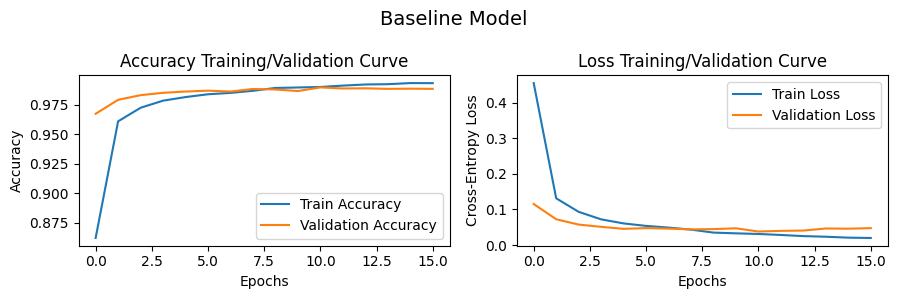

Final Results after 10 epochs:
Accuracy: Train=98.99% | Val=98.95%
Loss: Train=0.0311 | Val=0.0380


In [3]:
### Plot training and validation curves ###

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Accuracies plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Accuracy Training/Validation Curve')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Losses plot
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss Training/Validation Curve')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Cross-Entropy Loss')
axes[1].legend()

# Show plots
fig.suptitle('Baseline Model', fontsize=14)
plt.tight_layout()
plt.show()

restore_weights_idx = -early_stopping.patience - 1
print(f'Final Results after {len(history.history['accuracy']) + restore_weights_idx} epochs:')
print(f'Accuracy: Train={history.history['accuracy'][restore_weights_idx] * 100:.2f}% | Val={history.history['val_accuracy'][restore_weights_idx] * 100:.2f}%')
print(f'Loss: Train={history.history['loss'][restore_weights_idx]:.4f} | Val={history.history['val_loss'][restore_weights_idx]:.4f}')

In [4]:
### Save the model ###

model.save('models/cnn_baseline_model.keras')